# Stock Chart Pattern Recognition Using Deep learning

# Deep Learning Financial Workflow - Cassandra Integration

In [8]:

from cassandra.cluster import Cluster
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# TensorFlow / Keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Conv1D, MaxPooling1D, Flatten
from sklearn.preprocessing import MinMaxScaler

# HuggingFace Transformers สำหรับ sentiment
from transformers import pipeline

# 1️⃣ ดึงข้อมูล OHLCV จาก Cassandra

In [9]:
def get_candlestick_data(symbol: str, limit: int = 3000):
    try:
        cluster = Cluster(['127.0.0.1'], port=9042)
        session = cluster.connect('stock_data')
        query = """
            SELECT time, open_price, high_price, low_price, close_price, volume
            FROM candlestick_data
            WHERE symbol = %s
            ORDER BY time DESC
            LIMIT %s
        """
        rows = session.execute(query, (symbol, limit))
        df = pd.DataFrame(list(rows))
        if df.empty:
            print(f"⚠️ ไม่พบข้อมูลสำหรับ symbol '{symbol}'")
            return pd.DataFrame()
        df.rename(columns={
            'open_price':'open', 'high_price':'high',
            'low_price':'low', 'close_price':'close'
        }, inplace=True)
        df.sort_values('time', inplace=True)
        df.reset_index(drop=True, inplace=True)
        return df
    except Exception as e:
        raise ConnectionRefusedError(f"❌ Cassandra error: {e}")
    finally:
        try: cluster.shutdown()
        except: pass

# 2️⃣ LSTM Price Prediction

In [10]:
def lstm_price_prediction(df: pd.DataFrame, seq_length=30):
    close = df['close'].values.reshape(-1,1)
    scaler = MinMaxScaler()
    close_scaled = scaler.fit_transform(close)

    # สร้าง sequence
    X, y = [], []
    for i in range(len(close_scaled)-seq_length):
        X.append(close_scaled[i:i+seq_length])
        y.append(close_scaled[i+seq_length])
    X, y = np.array(X), np.array(y)

    split = int(len(X)*0.8)
    X_train, X_test = X[:split], X[split:]
    y_train, y_test = y[:split], y[split:]

    model = Sequential()
    model.add(LSTM(64, input_shape=(seq_length,1)))
    model.add(Dense(1))
    model.compile(loss='mse', optimizer='adam')
    model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.1, verbose=1)

    y_pred = model.predict(X_test)
    y_pred_rescaled = scaler.inverse_transform(y_pred)
    return y_pred_rescaled, y_test

# 3️⃣ CNN Pattern Recognition (Head & Shoulders)

In [11]:
def generate_hs_labels(df: pd.DataFrame):
    df = df.copy()
    df['local_max'] = df['close'][(df['close'].shift(1)<df['close']) & (df['close'].shift(-1)<df['close'])]
    local_max_idx = df['local_max'].dropna().index
    labels = np.zeros(len(df))
    for i in range(len(local_max_idx)-2):
        ls_idx, head_idx, rs_idx = local_max_idx[i], local_max_idx[i+1], local_max_idx[i+2]
        ls_price, head_price, rs_price = df.loc[ls_idx,'close'], df.loc[head_idx,'close'], df.loc[rs_idx,'close']
        if head_price>ls_price and head_price>rs_price and abs(ls_price-rs_price)/ls_price<0.05:
            labels[ls_idx:rs_idx+1]=1
    return labels

def cnn_hs_recognition(df: pd.DataFrame, seq_length=30):
    labels = generate_hs_labels(df)
    data = df['close'].values.reshape(-1,1)
    scaler = MinMaxScaler()
    data_scaled = scaler.fit_transform(data)

    # สร้าง sequence windows
    X, y = [], []
    for i in range(len(data_scaled)-seq_length):
        X.append(data_scaled[i:i+seq_length])
        y.append(labels[i+seq_length])
    X, y = np.array(X), np.array(y)

    split = int(len(X)*0.8)
    X_train, X_test = X[:split], X[split:]
    y_train, y_test = y[:split], y[split:]

    # CNN 1D model
    model = Sequential()
    model.add(Conv1D(32, kernel_size=3, activation='relu', input_shape=(seq_length,1)))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.1, verbose=1)

    y_pred = model.predict(X_test).flatten()
    return y_pred, y_test, split

# 4️⃣ Sentiment Analysis (Transformer)

In [12]:
def sentiment_analysis(text_list):
    classifier = pipeline("sentiment-analysis")
    results = classifier(text_list)
    return results

# 5️⃣ Visualization Example

In [13]:
def plot_cnn_predictions(df, y_pred, split, seq_length=30):
    plt.figure(figsize=(15,6))
    plt.plot(df['time'], df['close'], label='Close Price')
    hs_idx = np.where(np.concatenate([np.zeros(seq_length+split), y_pred])>0.5)[0]
    plt.scatter(df.loc[hs_idx,'time'], df.loc[hs_idx,'close'], color='red', label='Predicted H&S')
    plt.title("Head & Shoulders Detection")
    plt.xlabel("Time")
    plt.ylabel("Close")
    plt.legend()
    plt.grid(True)
    plt.show()


# 6️⃣ MAIN PIPELINE

Epoch 1/10


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.3848 - val_loss: 0.0028
Epoch 2/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0254 - val_loss: 0.0035
Epoch 3/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0137 - val_loss: 0.0031
Epoch 4/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0095 - val_loss: 0.0110
Epoch 5/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0086 - val_loss: 0.0051
Epoch 6/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0076 - val_loss: 0.0063
Epoch 7/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0082 - val_loss: 0.0057
Epoch 8/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0074 - val_loss: 0.0053
Epoch 9/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0091 - val_loss: 0.0055
Epoch 10/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0082 - val_loss: 0.0048
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/stepWARNING:tensorflow:6 out of the last 9 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distrib

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.4097 - loss: 0.6969 - val_accuracy: 0.8684 - val_loss: 0.6723
Epoch 2/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5191 - loss: 0.6913 - val_accuracy: 0.8421 - val_loss: 0.6631
Epoch 3/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5034 - loss: 0.6918 - val_accuracy: 0.8421 - val_loss: 0.6636
Epoch 4/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5510 - loss: 0.6819 - val_accuracy: 0.8158 - val_loss: 0.6596
Epoch 5/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4955 - loss: 0.6919 - val_accuracy: 0.8684 - val_loss: 0.6788
Epoch 6/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5247 - loss: 0.6873 - val_accuracy: 0.2632 - val_loss: 0.6924
Epoch 7/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5588 - loss: 0.6820 - val_accuracy: 0.4737 - val_loss: 0.6881
Epoch 8/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5392 - loss: 0.6766 - val_accuracy: 0.2895 - val_loss: 0.7072
Ep

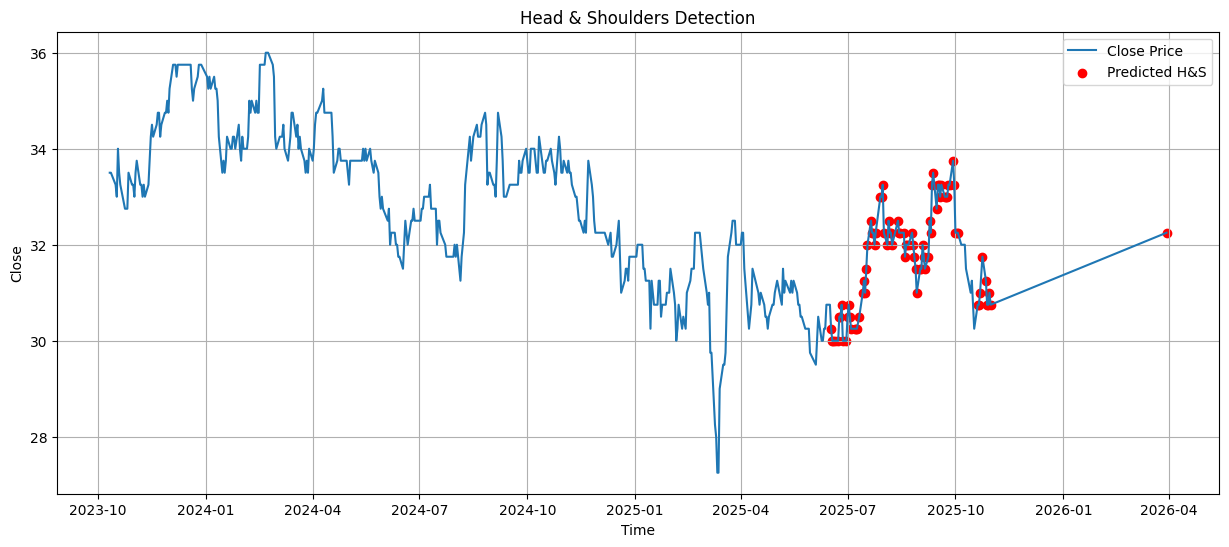

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
Device set to use mps:0


✅ Sentiment Analysis: [{'label': 'POSITIVE', 'score': 0.9986163377761841}, {'label': 'NEGATIVE', 'score': 0.9997183680534363}]


In [14]:
if __name__ == "__main__":
    symbol = 'PTT'
    df = get_candlestick_data(symbol, limit=500)
    if df.empty:
        print("No data from Cassandra")
    else:
        # 1️⃣ LSTM Price Prediction
        y_pred_price, y_test_price = lstm_price_prediction(df)
        print("✅ LSTM price prediction done")

        # 2️⃣ CNN H&S Recognition
        y_pred_hs, y_test_hs, split = cnn_hs_recognition(df)
        print("✅ CNN H&S pattern recognition done")
        plot_cnn_predictions(df, y_pred_hs, split)

        # 3️⃣ Sentiment Analysis (example)
        texts = ["Bitcoin hits new all-time high!", "Market crashes due to regulation fears."]
        results = sentiment_analysis(texts)
        print("✅ Sentiment Analysis:", results)
